# Classifying Text with Feature Extraction from Transformers

In this notebook, I classify Reddit post titles and text into 'Conservative' or 'Liberal' posts. To accomplish this, I extract hidden representations of the data from a pretrained model (downloaded from HuggingFace), which I then use in a simple deep network to classify the titles.

The data can be found [here](http://www.kaggle.com/datasets/neelgajare/liberals-vs-conservatives-on-reddit-13000-posts).

I referenced many materials to complete this and related notebooks, including [*Deep Learning with Python*](http://https://www.manning.com/books/deep-learning-with-python) by François Chollet and [*Natural Language Processing with Transformers*](http://https://www.oreilly.com/library/view/natural-language-processing/9781098103231/) by Lewis Tunstall, Leandro von Werra, Thomas Wolf.


In [1]:
# imports and installs

import numpy as np
import pandas as pd
        
!pip install -U transformers
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 7.2 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.18.0
    Uninstalling transformers-4.18.0:
      Successfully uninstalled transformers-4.18.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
allennlp 2.9.3 requires transformers<4.19,>=4.1, but you have transformers 4.19.2 which is incompatible.


In [2]:
# load data into HuggingFace dataset
# data can be found: https://www.kaggle.com/datasets/neelgajare/liberals-vs-conservatives-on-reddit-13000-posts

from datasets import load_dataset
dataset = load_dataset('csv', data_files='../input/liberals-vs-conservatives-on-reddit-13000-posts/file_name.csv')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-fc9590c0949f0926/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [3]:
# change format to pandas dataframe to preprocess data 

dataset.set_format(type="pandas")
df = dataset["train"][:]
df = df.dropna()
df = df.drop(columns=['Score', 'Id', 'Subreddit', 'URL', 'Num of Comments','Date Created'])
df.sample(frac=1)

,Title,Political Lean,Text
11759,IQ test,Conservative,How do you define capitalism? Keep in mind tha...
11184,Socialists trying to sound like saints?,Conservative,What is all this crap with Socialists trying t...
10506,What's the Libertarian solution to Israel and ...,Conservative,What should Israel do from a Libertarian persp...
5833,I'm new here,Liberal,I always considered myself a republican with f...
10347,"U,S, Mock Government",Conservative,"We’re a U,S, mock government server with a wid..."
...,...,...,...
12145,Do you own a business?,Conservative,\n\n[View Poll](https://www.reddit.com/poll/qk...
4852,Are the european welfare states sustainable?,Liberal,"Hi there, i was just wondering if you think th..."
10380,Member of parliament HAS HIS AUDIO CUT during ...,Conservative,Here is the video: \nhttps://imgur.com/a/z...
1719,What's something you think everyone should kno...,Liberal,I think social democracy has yet to be found b...


In [4]:
# concatenate text & title features, doubling the title to represent increased importance
# take a look at a total_text sample

df["total_text"] = df["Title"] + " " + df["Title"] + " " + df["Text"]
df = df.drop(columns=['Title', 'Text'])
df['total_text'][11]

"Be careful when you post to r/politics and r/askreddit - trolls are trying to get you banned Be careful when you post to r/politics and r/askreddit - trolls are trying to get you banned I have fallen for this trap several times and got temp banned in both these subreddits. Trolls will goat you on and you end saying something less than civil. They then report your comment, and delete theirs. It makes it look like you are the one being uncivil. You end up getting banned. \n\nIt's my own fault for saying what I did, and will serve my sentence. I mean we all should be civil regardless. But know their goal is not to debate. It's to get you banned."

In [5]:
# encode labels

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(df["Political Lean"])
df["Political Lean"] = le.transform(df["Political Lean"])

In [6]:
# convert back into HuggingFace dataset

from datasets import Dataset

politics = Dataset.from_pandas(df)
politics

Dataset({
    features: ['Political Lean', 'total_text', '__index_level_0__'],
    num_rows: 2428
})

In [7]:
# split the data into 90% train, 5% val, and 5% test
train_test = politics.train_test_split(test_size=0.1)
test_valid = train_test['test'].train_test_split(test_size=0.5)

# gather splits into single dataset
from datasets import DatasetDict
politics = DatasetDict({
    'train': train_test['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']})
politics = politics.remove_columns(['__index_level_0__'])
politics


DatasetDict({
    train: Dataset({
        features: ['Political Lean', 'total_text'],
        num_rows: 2185
    })
    test: Dataset({
        features: ['Political Lean', 'total_text'],
        num_rows: 122
    })
    valid: Dataset({
        features: ['Political Lean', 'total_text'],
        num_rows: 121
    })
})

In [8]:
# tokenizing the text from pretrained model

from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [9]:
# tokenize all data

def tokenize(batch):
    return tokenizer(batch["total_text"], padding=True, truncation=True)

politics_encoded = politics.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [10]:
# download and instantiate model

from transformers import AutoModel

model = AutoModel.from_pretrained(model_ckpt)
model = model.to("cuda")

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [11]:
# define function to extract hidden states from model for data

import torch

def extract_hidden_states(batch):
    inputs = {key: batch[key].to("cuda") for key in ["input_ids", "attention_mask"]}
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    return {"hidden_state": last_hidden_state[:,0].detach().cpu().numpy()}


In [12]:
# convert tokenized text into pytorch tensors

politics_encoded.set_format("torch", 
                            columns=["input_ids", "attention_mask", "Political Lean"])

In [13]:
# extract hidden states from model for all data and look at a hidden tensor

politics_hidden = politics_encoded.map(extract_hidden_states, batched=True, batch_size=1)
politics_hidden["train"][1]

  0%|          | 0/2185 [00:00<?, ?ba/s]

  0%|          | 0/122 [00:00<?, ?ba/s]

  0%|          | 0/121 [00:00<?, ?ba/s]

{'Political Lean': tensor(1),
 'input_ids': tensor([  101,  2308,  2079,  2031,  1996,  2157,  2000,  2377,   999,  2308,
          2079,  2031,  1996,  2157,  2000,  2377,   999,  1999,  4501,  2009,
          2038,  2042,  2464,  2008,  2308,  2024,  2025,  2893,  2008,  2172,
          9592,  1999,  1996,  2492,  1997,  2998,  2004,  2273,  2029,  2003,
          2893,  2068,  6171,  1999,  6245,  1998,  2037,  7023,  3798,  2024,
          7510,  2091,   999,  2005,  2308, 23011,  2009,  1005,  1055,  2442,
          2000,  2031,  7023,  1998,  2998,  2003,  1996,  2126,  2000,  2079,
          2008,   999,  1031,  2998,  2005,  2308,   999,  1033,  1006, 16770,
          1024,  1013,  1013,  1996, 16409,  5358,  3672,  1012, 23012, 11008,
          1012,  4012,  1013, 12609,  1013,  2260,  1013,  2998,  1011,  2005,
          1011,  2308,  1011,  1999,  1011,  4501,  1012, 16129,  1007,   102,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
         

In [14]:
# convert data to numpy arrays 

import numpy as np

X_train = np.array(politics_hidden["train"]["hidden_state"])
X_valid = np.array(politics_hidden["valid"]["hidden_state"])
y_train = np.array(politics_hidden["train"]["Political Lean"])
y_valid = np.array(politics_hidden["valid"]["Political Lean"])
X_test = np.array(politics_hidden["test"]["hidden_state"])
y_test = np.array(politics_hidden["test"]["Political Lean"])
X_train.shape, X_valid.shape

((2185, 768), (121, 768))

In [15]:
# using hidden states, train on simple dense network

from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train,
                    y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(X_valid, y_valid))

2022-05-27 18:59:28.046142: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-27 18:59:28.047283: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-27 18:59:28.047944: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-27 18:59:28.048908: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Epoch 1/20
5/5 [==============================] - 1s 45ms/step - loss: 0.7662 - accuracy: 0.5561 - val_loss: 0.6667 - val_accuracy: 0.5702
Epoch 2/20
5/5 [==============================] - 0s 8ms/step - loss: 0.6396 - accuracy: 0.6325 - val_loss: 0.6476 - val_accuracy: 0.6033
Epoch 3/20
5/5 [==============================] - 0s 7ms/step - loss: 0.6542 - accuracy: 0.6288 - val_loss: 0.6628 - val_accuracy: 0.5785
Epoch 4/20
5/5 [==============================] - 0s 7ms/step - loss: 0.6019 - accuracy: 0.6746 - val_loss: 0.7250 - val_accuracy: 0.4959
Epoch 5/20
5/5 [==============================] - 0s 7ms/step - loss: 0.6259 - accuracy: 0.6444 - val_loss: 0.6478 - val_accuracy: 0.6033
Epoch 6/20
5/5 [==============================] - 0s 7ms/step - loss: 0.5872 - accuracy: 0.6769 - val_loss: 0.6382 - val_accuracy: 0.6116
Epoch 7/20
5/5 [==============================] - 0s 7ms/step - loss: 0.5760 - accuracy: 0.6943 - val_loss: 0.6466 - val_accuracy: 0.6446
Epoch 8/20
5/5 [=================

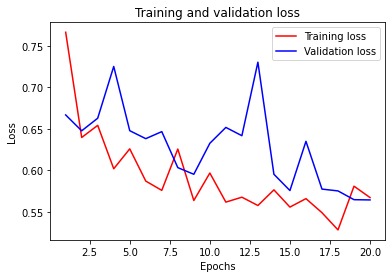

In [16]:
# plot loss over epochs

import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "r", label="Training loss") # "b--" is for "blue dashed line"
plt.plot(epochs, val_loss_values, "b", label="Validation loss") # b is for "solid blue line"
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [17]:
# get test metrics

from sklearn import metrics

preds = model(X_test)
preds = preds.numpy()
preds = preds>0.5

print("Accuracy is", metrics.accuracy_score(y_test, preds))
print("F1 score is", metrics.f1_score(y_test, preds))
print("Precision is", metrics.precision_score(y_test, preds))
print("Recall is", metrics.recall_score(y_test, preds))

Accuracy is 0.7295081967213115
F1 score is 0.7785234899328859
Precision is 0.7837837837837838
Recall is 0.7733333333333333


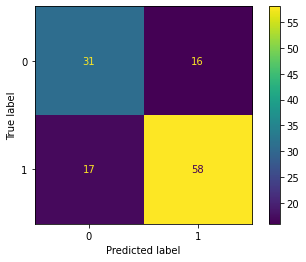

In [18]:
# looking at the confusion matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

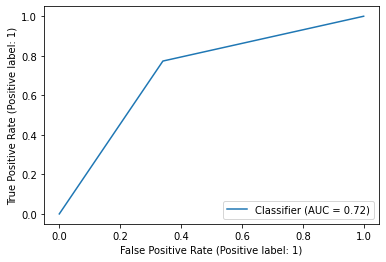

In [19]:
from sklearn.datasets import make_classification
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(y_test, preds)